# Convolution Neural Networks Forward pass.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#Defauling various parameters of the plots.
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

- Convolution functions, including:
    - Zero Padding
    - Convolve window 
    - Convolution forward
- Pooling functions, including:
    - Pooling forward
    - Create mask 
    - Distribute value 

In [3]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X, ((0,0),(pad,pad), (pad,pad), (0,0)), mode = 'constant')
    
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 2.26975462 -1.45436567]
 [ 0.04575852 -0.18718385]
 [ 1.53277921  1.46935877]]
x_pad[1,1] = [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


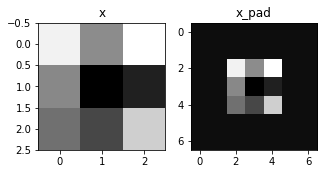

In [10]:
np.random.seed(0)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig, ax = plt.subplots(1, 2) #Returns the figure object and the axes object for each subplot as a sequence.
ax[0].set_title('x')
ax[0].imshow(x[0,:,:,0])
ax[1].set_title('x_pad')
ax[1].imshow(x_pad[0,:,:,0])

In [12]:
def conv_single_step(a_slice_prev, W, b):
    """
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """

    #Applying Convolution operation i.e., element wise multiplication of the image slice
    #and the filter, and then summing over all the products.
    s = a_slice_prev * W
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = Z + b
    
    return Z

In [13]:
np.random.seed(0)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = [[[ 4.64938139]]]


## Forward Pass


**Formulae**:
The formulas relating the output shape of the convolution to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$

In [18]:
def conv_forward(A_prev, W, b, hparameters):
    
    """
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # Retrieve dimensions from A_prev's shape 
    (m, n_H_prev, n_W_prev, n_C_prev) = np.shape(A_prev)
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = np.shape(W)
    
    # Retrieve information from "hparameters"
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above.
    n_H = int(((n_H_prev + 2*pad - f) / stride) + 1)
    n_W = int(((n_W_prev + 2*pad - f) / stride) + 1)
    
    # Initialize the output volume Z with zeros.
    Z = np.zeros([m, n_H, n_W, n_C])
    
    # Zero padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):  # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]  # Select ith training example.
        for h in range(n_H):  # loop over vertical axis of the output volume, rows.
            for w in range(n_W):  # loop over horizontal axis of the output volume, columns.
                for c in range(n_C):  # loop over channels (= #filters) of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad.
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron.
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:, :, :, c], b[:, :, :, c])
                                           
    # Making sure the output shape is correct  
    #(A good to have step specially when you are dealing with multi-dimensional arrays)
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [19]:
np.random.seed(0)
A_prev = np.random.randn(10,4,4,3) #10 examples of shape 4*4*3
W = np.random.randn(2,2,3,8) #8 filter weights of shape 2*2*3
b = np.random.randn(1,1,1,8) #8 biases, one for each filter.
hparameters = {"pad" : 2,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = -0.44995195888
Z[3,2,1] = [-1.02306706 -1.6233959  -1.18566576  1.26399162  2.92191922 -0.65072981
  5.39531179  2.93454894]
cache_conv[0][1][2][3] = [ 0.90082649  0.46566244 -1.53624369]


### 4.1 - Forward Pooling

**Formulae**:
As there's no padding, the formulas binding the output shape of the pooling to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$
$$ n_C = n_{C_{prev}}$$

In [20]:
# GRADED FUNCTION: pool_forward

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    
                    # Finding corners
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c.
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # Compute the pooling operation on the slice.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.average(a_prev_slice)
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure the output shape is correct.
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [22]:
np.random.seed(0)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[ 2.26975462  1.86755799  1.46935877]]]


 [[[ 1.13940068  0.46278226  0.40234164]]]]

mode = average
A = [[[[ 0.95559244  0.37051027 -0.19874578]]]


 [[[-0.57123121 -0.2293351  -0.60816277]]]]
